In [2]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
def system_dynamics(x_t, u_t):
    """
    System dynamics: x_t+1 = x_t + 0.5*u_t
    """
    return x_t + 0.5 * u_t

def analytical_controller(x_t):
    """
    Analytical control law to make x_t+1 = 0
    """
    return -2 * x_t

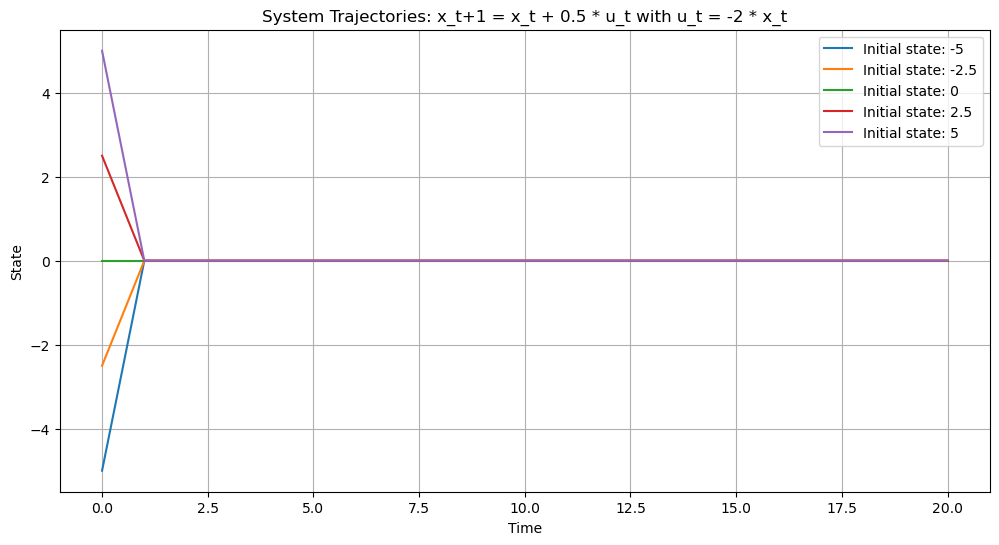

In [4]:
# Data
n_steps = 20
x0_vals = [-5, -2.5, 0, 2.5, 5]
np.array(x0_vals)
time_steps = np.arange(n_steps + 1)

x_history = np.zeros((len(x0_vals), n_steps + 1))
u_history = np.zeros((len(x0_vals), n_steps))

for i, x0 in enumerate(x0_vals):
    x_history[i, 0] = x0
    for t in range(n_steps):
        u_t = analytical_controller(x_history[i, t])
        x_history[i, t + 1] = system_dynamics(x_history[i, t], u_t)
        u_history[i, t] = u_t

plt.figure(figsize=(12, 6))
for i in range(len(x0_vals)):
    plt.plot(time_steps, x_history[i], label=f'Initial state: {x0_vals[i]}')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('System Trajectories: x_t+1 = x_t + 0.5 * u_t with u_t = -2 * x_t')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
# Generate training data
x_data = np.random.uniform(-10, 10, (1000,1))
u_data = analytical_controller(x_data)  # Generate corresponding control inputs

x_train, x_test, u_train, u_test = train_test_split(
    x_data, 
    u_data.reshape(-1, 1), 
    test_size=0.2, 
    random_state=42
)
inputs = Input(shape=(1,))
dense = Dense(64, activation='relu')(inputs)
dense = Dense(64, activation='relu')(dense)
outputs = Dense(1, activation='linear')(dense)

In [6]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, u_train, epochs=100, batch_size=32, validation_split=0.2)
predictions = model.predict(x_test)
r2 = r2_score(u_test, predictions)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 126.3358 - val_loss: 71.0032
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.2013 - val_loss: 36.0828
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.1947 - val_loss: 18.7909
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.6827 - val_loss: 6.0604
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6686 - val_loss: 0.6156
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3311 - val_loss: 0.1095
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1051 - val_loss: 0.1008
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0982 - val_loss: 0.0940
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0900 - val_loss: 0.0859
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0721 - val_loss: 0.0823
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0742 - val_loss: 0.0705
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - l

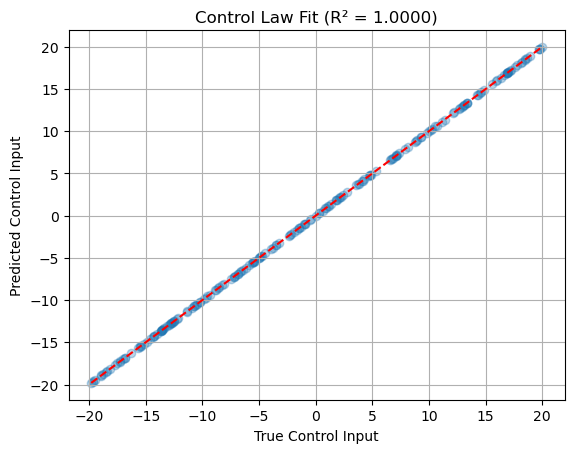

In [7]:
plt.scatter(u_test, predictions, alpha=0.3)
plt.plot([u_test.min(), u_test.max()], [u_test.min(), u_test.max()], 'r--')
plt.xlabel('True Control Input')
plt.ylabel('Predicted Control Input')
plt.title(f'Control Law Fit (R² = {r2:.4f})')
plt.grid()

plt.show()

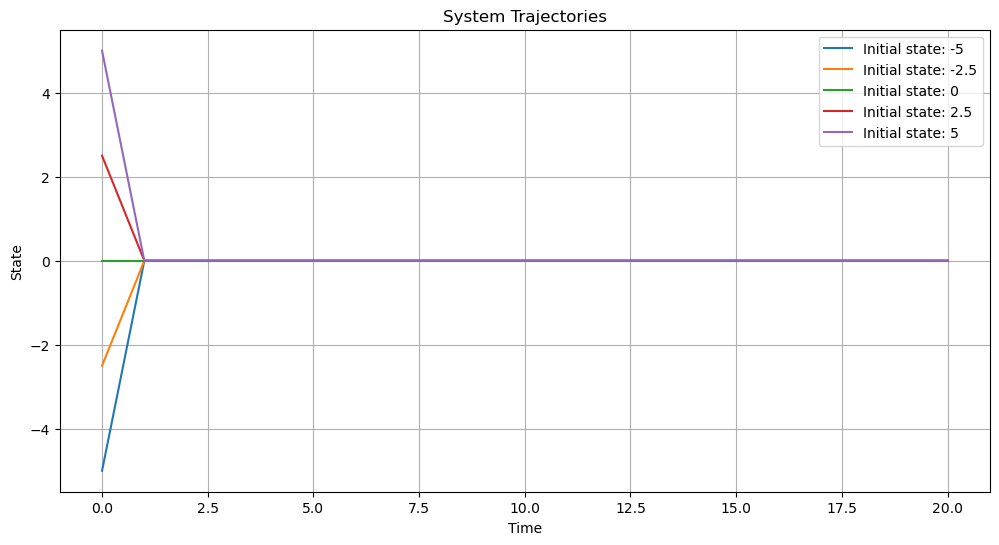

In [8]:
# Data
n_steps = 20
x0_vals = [-5, -2.5, 0, 2.5, 5]
np.array(x0_vals)
time_steps = np.arange(n_steps + 1)

x_history = np.zeros((len(x0_vals), n_steps + 1))
u_history = np.zeros((len(x0_vals), n_steps))

for i, x0 in enumerate(x0_vals):
    x_history[i, 0] = x0
    for t in range(n_steps):
        u_t = analytical_controller(x_history[i, t])
        x_history[i, t + 1] = system_dynamics(x_history[i, t], u_t)
        u_history[i, t] = u_t

plt.figure(figsize=(12, 6))
for i in range(len(x0_vals)):
    plt.plot(time_steps, x_history[i], label=f'Initial state: {x0_vals[i]}')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('System Trajectories')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
inputs = Input(shape=(1,))
dense = Dense(64, activation='relu')(inputs)
dense = Dense(64, activation='relu')(dense)
outputs = Dense(1, activation='linear')(dense)

controller_model = Model(inputs=inputs, outputs=outputs)
controller_model.compile(optimizer='adam', loss='mse')

In [10]:
epochs = 1000
losses = []
with tf.device('/gpu:0'):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            total_loss = 0
            current_state = x_history[:, 0].reshape(-1, 1).astype(np.float32)
    
            for t in range(20):
                u_t = controller_model(current_state)
                next_state = system_dynamics(current_state, u_t)
                total_loss += tf.reduce_mean(next_state**2)  
                current_state = next_state
            
            loss = total_loss / 20  # Average loss over timesteps
        gradients = tape.gradient(loss, controller_model.trainable_variables)
        controller_model.optimizer.apply_gradients(zip(gradients, controller_model.trainable_variables))
        losses.append(float(loss))
    
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

Epoch 10, Loss: 2.6396
Epoch 20, Loss: 1.3912
Epoch 30, Loss: 1.0044
Epoch 40, Loss: 0.7973
Epoch 50, Loss: 0.6364
Epoch 60, Loss: 0.5101
Epoch 70, Loss: 0.4055
Epoch 80, Loss: 0.3264
Epoch 90, Loss: 0.2640
Epoch 100, Loss: 0.2128
Epoch 110, Loss: 0.1708
Epoch 120, Loss: 0.1363
Epoch 130, Loss: 0.1081
Epoch 140, Loss: 0.0853
Epoch 150, Loss: 0.0667
Epoch 160, Loss: 0.0517
Epoch 170, Loss: 0.0399
Epoch 180, Loss: 0.0305
Epoch 190, Loss: 0.0230
Epoch 200, Loss: 0.0172
Epoch 210, Loss: 0.0128
Epoch 220, Loss: 0.0094
Epoch 230, Loss: 0.0067
Epoch 240, Loss: 0.0047
Epoch 250, Loss: 0.0033
Epoch 260, Loss: 0.0023
Epoch 270, Loss: 0.0016
Epoch 280, Loss: 0.0011
Epoch 290, Loss: 0.0008
Epoch 300, Loss: 0.0006
Epoch 310, Loss: 0.0004
Epoch 320, Loss: 0.0003
Epoch 330, Loss: 0.0002
Epoch 340, Loss: 0.0001
Epoch 350, Loss: 0.0001
Epoch 360, Loss: 0.0001
Epoch 370, Loss: 0.0001
Epoch 380, Loss: 0.0001
Epoch 390, Loss: 0.0001
Epoch 400, Loss: 0.0001
Epoch 410, Loss: 0.0001
Epoch 420, Loss: 0.0001
E

In [11]:
x_test = np.linspace(-10, 10, 100).reshape(-1, 1)
u_pred = controller_model.predict(x_test[:, 0].reshape(-1, 1).astype(np.float32))
r2 = r2_score(analytical_controller(x_test), u_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


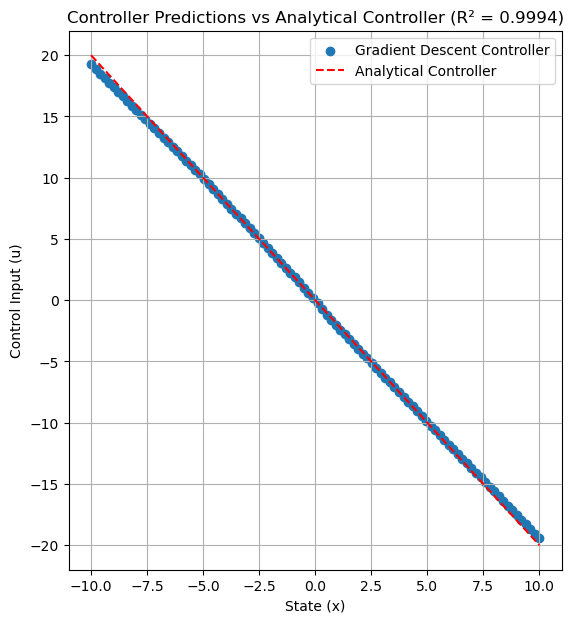

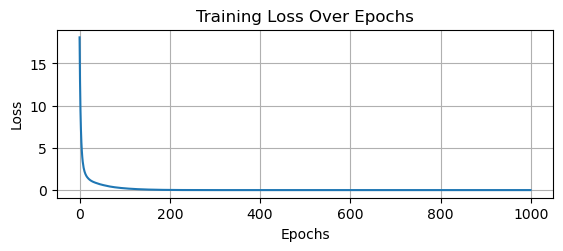

In [12]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(x_test, u_pred, label= 'Gradient Descent Controller')
plt.plot(x_test, analytical_controller(x_test), 'r--', label='Analytical Controller')
plt.grid()
plt.xlabel('State (x)')
plt.ylabel('Control Input (u)')
plt.title(f'Controller Predictions vs Analytical Controller (R² = {r2:.4f})')
plt.legend()
plt.show()

plt.subplot(2, 1, 1)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.show()